In [1]:
import sys, os
sys.path.append('..')

# Visualization
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
import seaborn as sns
sns.set_style("darkgrid")
mpl.style.use('ggplot')

import pandas as pd

from source import pipeline, model, data_utils, features

In [2]:
config = {
    'build_dir': '_build/',
    'target': 'Winner',
    'features':  ['seed_num_team_1', 'seed_num_team_2', 'seed_diff',
                  'kenpom_adj_o_team1', #'kenpom_adj_o_team2',
                  'kenpom_adj_o_diff', 'kenpom_adj_o_rank_team1',
                  #'kenpom_adj_o_rank_team2',
                  'kenpom_adj_o_rank_diff',
                  'kenpom_adj_d_team1', #'kenpom_adj_d_team2',
                  'kenpom_adj_d_diff',
                  'kenpom_adj_d_rank_team1',
                  #'kenpom_adj_d_rank_team2',
                  'kenpom_adj_d_rank_diff', 
                  'kenpom_rank_team1', #'kenpom_rank_team2',
                  'kenpom_rank_diff', 'kenpom_luck_team1', #'kenpom_luck_team2',
                  'kenpom_luck_diff', 'kenpom_adjem_team1', #'kenpom_adjem_team2',
                  'kenpom_adjem_diff'],
    'model_params': {
        'categorical_features': None,
        'n_estimators': 250,  # Number of trees to fit.
        'early_stopping_rounds':20,
        'eval_metric': 'binary_logloss',
        'min_data_per_group': 3,
        'learning_rate': 0.01,
        'num_leaves': 10
    }
}

In [3]:
pipeline.build(config)

Creating evaluation set
Training lightgbm model on 642 x 17 data set
Early stopping in effect (rounds = 20)
[LightGBM] [Warning] Unknown parameter: sparsify
[LightGBM] [Warning] Unknown parameter: target
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] num_threads is set=0, n_jobs=-1 will be ignored. Current value: num_threads=0
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] Unknown parameter: sparsify
[LightGBM] [Warning] Unknown parameter: target
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] num_threads is set=0, n_jobs=-1 will be ignored. Current value: num_threads=0
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Info] Number

/Users/jwrichar/miniconda/envs/py3/lib/python3.6/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


Loading model from file


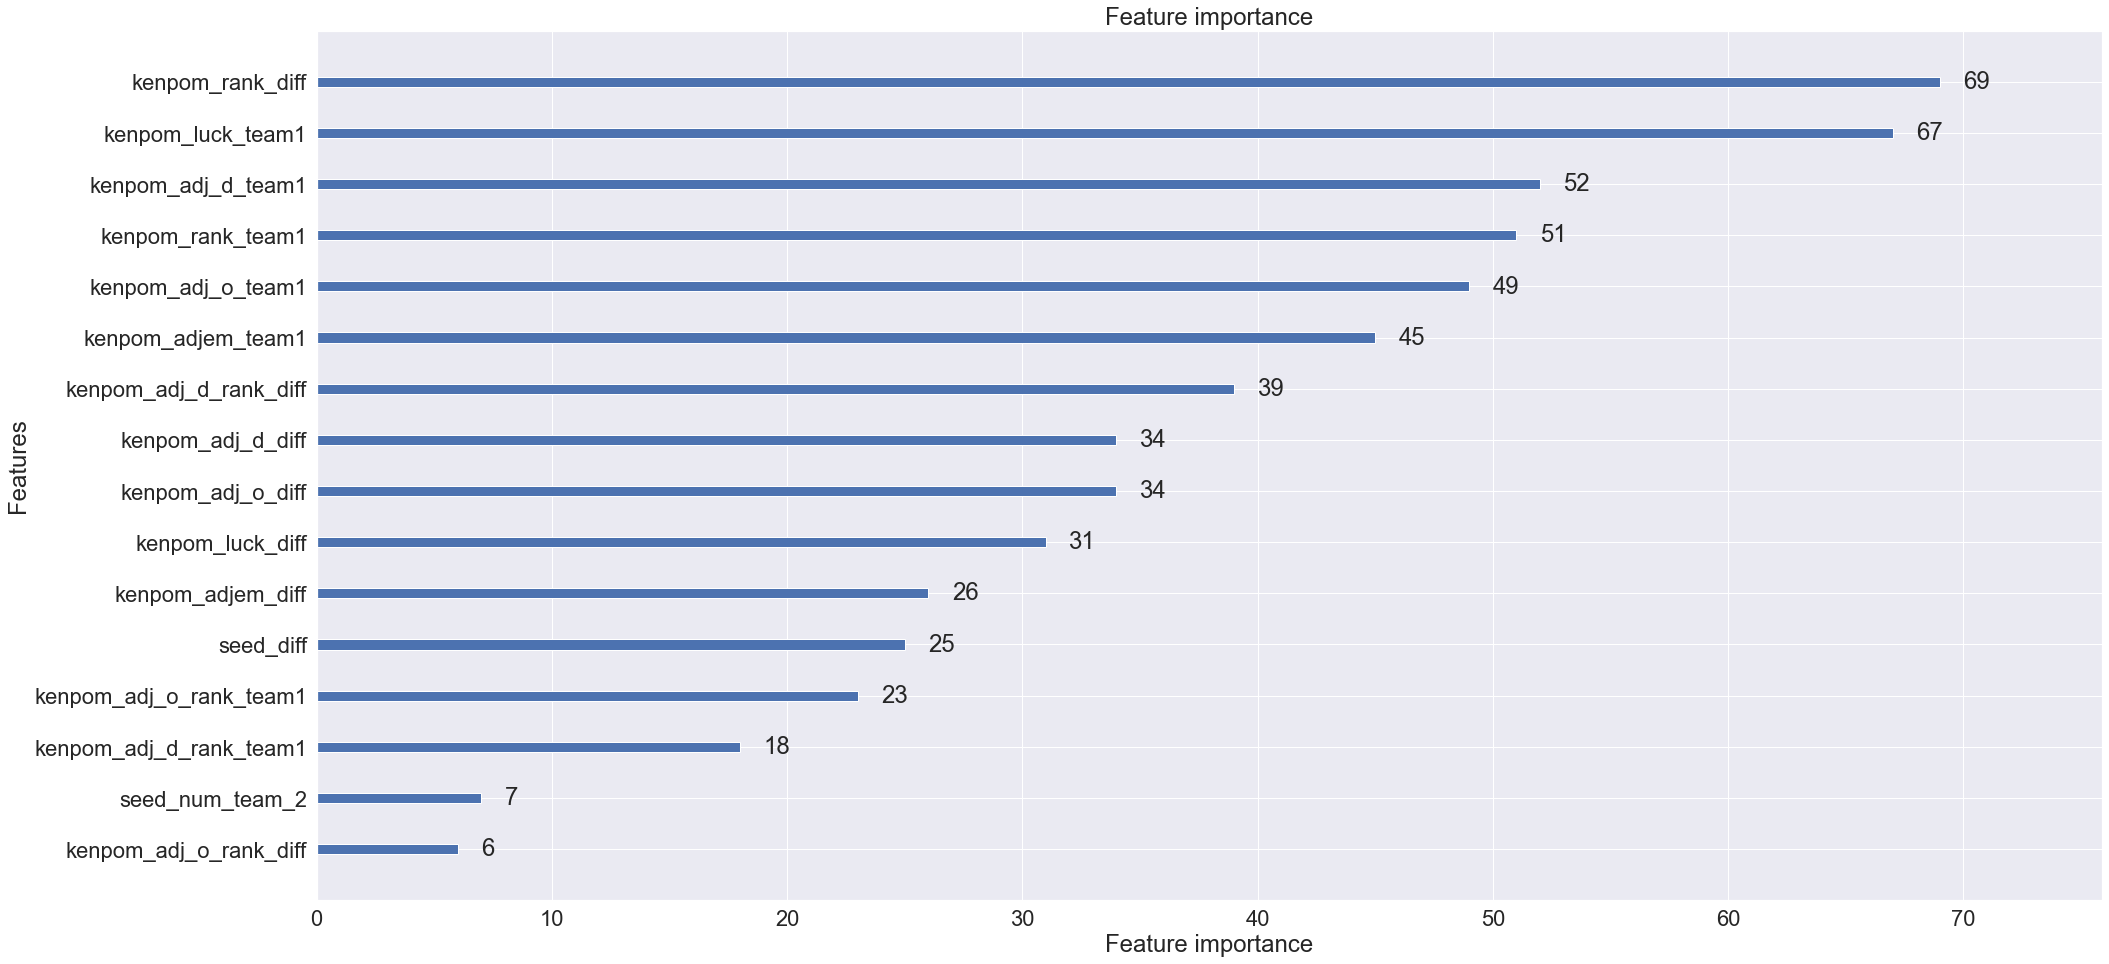

In [4]:
import lightgbm
os.environ['BUILD_DIR'] = '_build/'

m = model.BoostingModel()
m.load()

sns.set(rc={'figure.figsize':(32,16)})
sns.set(font_scale = 2)
lightgbm.plot_importance(m.model)

In [5]:
# Run a simple train-test
df = data_utils.compile_training_data(2011, 2023)

# Add kenpom features to master df
features.add_kenpom_features(df)

params = config['model_params']
params['target'] = 'Winner'

# Holdout on season
frac=0.1
y_true, y_pred = model.train_test(df, params, holdout_sort='column', column='Season', frac=frac)

Performing holdout split of 0.10 fraction of data of type "column".
Creating evaluation set
Training lightgbm model on 577 x 28 data set
Early stopping in effect (rounds = 20)
[LightGBM] [Warning] Unknown parameter: sparsify
[LightGBM] [Warning] Unknown parameter: target
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] num_threads is set=0, n_jobs=-1 will be ignored. Current value: num_threads=0
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] Unknown parameter: sparsify
[LightGBM] [Warning] Unknown parameter: target
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] num_threads is set=0, n_jobs=-1 will be ignored. Current value: num_threads=0
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be

/Users/jwrichar/miniconda/envs/py3/lib/python3.6/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


In [6]:
split_params = {
    'sort': 'column',
    'fraction': frac,
    'column': 'Season'
}
df_train, df_test = model.split_data(df, split_params)

# Proportion correct
print('Model proportion correct:')
print((y_true == y_pred['values']).sum() / float(len(y_true)))

# Chalk prediction
y_pred_chalk = df_test['seed_diff'].apply(lambda x: 'Team1' if x <= 0 else 'Team2')
print('Chalk proportion correct:')
print((y_true == y_pred_chalk).sum() / float(len(y_true)))


Performing holdout split of 0.10 fraction of data of type "column".
Model proportion correct:
0.6790123456790124
Chalk proportion correct:
0.6790123456790124


In [7]:
print(pd.crosstab(y_true, y_pred['values']))

print(pd.crosstab(y_true, y_pred_chalk))


col_0   Team1
Winner       
Team1      55
Team2      26
seed_diff  Team1
Winner          
Team1         55
Team2         26


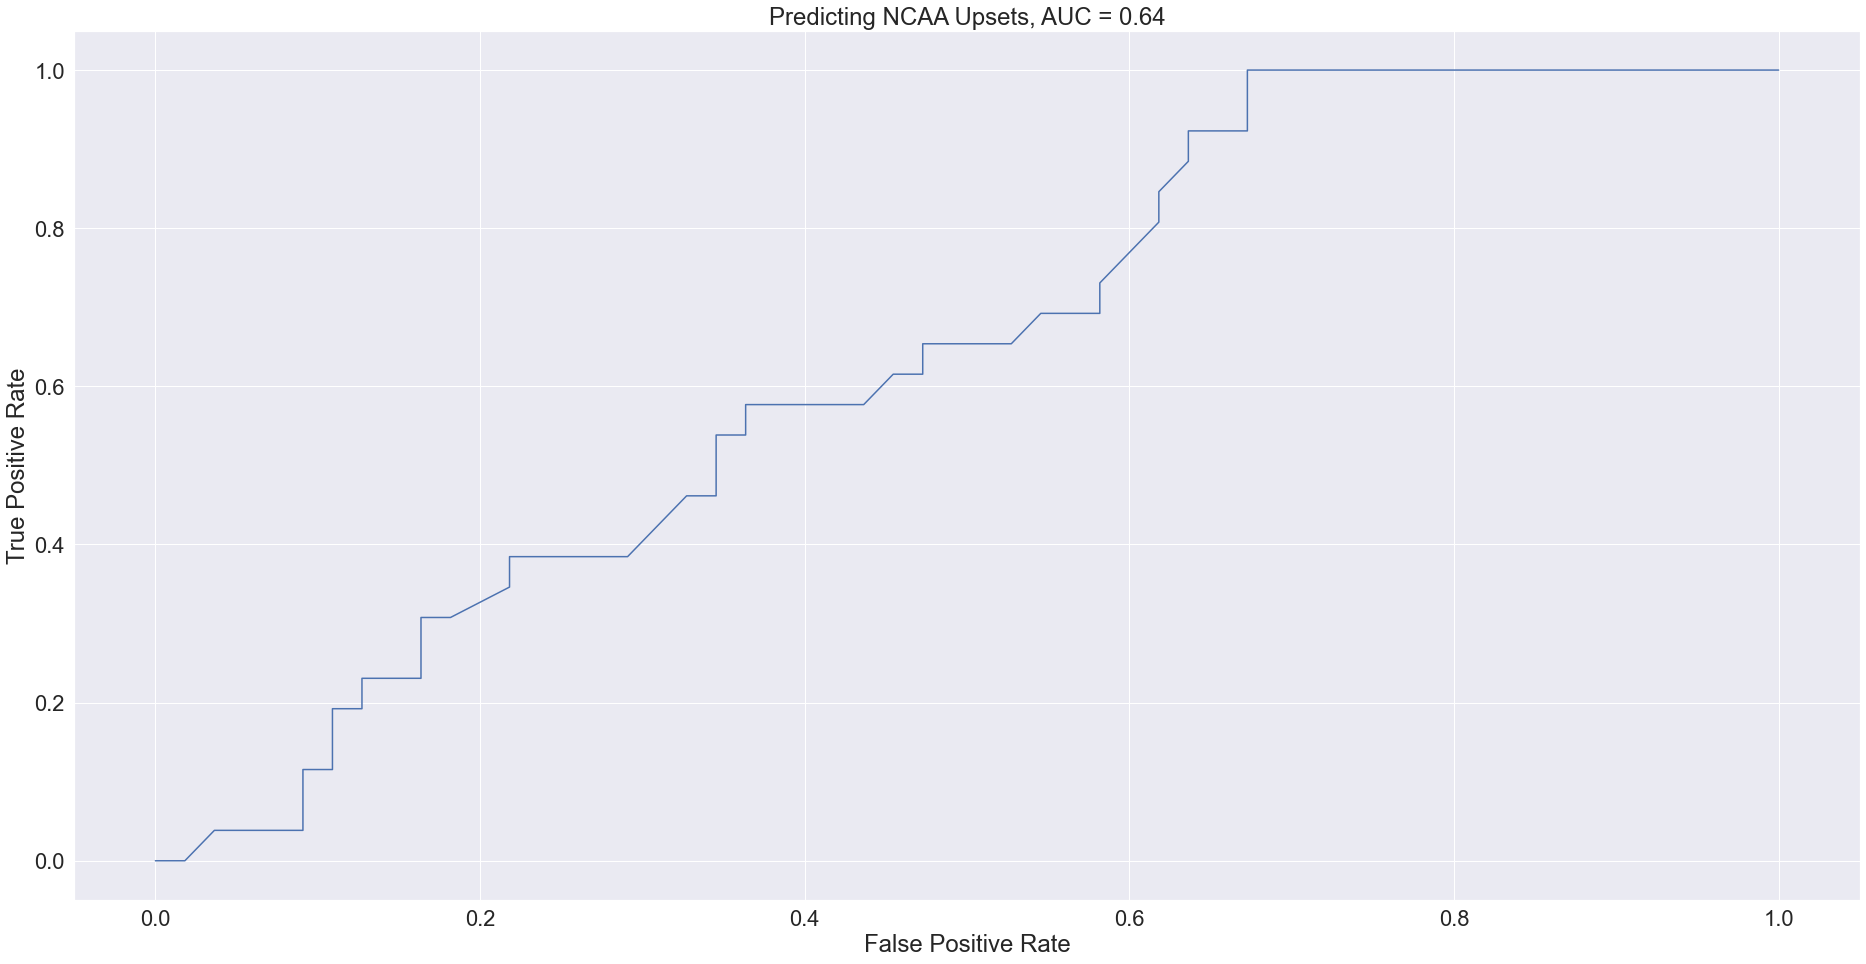

In [8]:
from sklearn import metrics
y_true_bool = y_true.apply(lambda x: 1 if x=='Team2' else 0)
fpr, tpr, thresholds = metrics.roc_curve(y_true_bool,  y_pred['scores']['Team2'])
auc = metrics.roc_auc_score(y_true_bool, y_pred['scores']['Team2'])

#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('Predicting NCAA Upsets, AUC = %.2f' % auc)
plt.plot([0, 0], [1, 1], 'r-', lw=3)

In [16]:
thresh_team2 = thresholds[abs(tpr - 0.4).argmin()]
print("Threshold:")
print(thresh_team2)
y_pred_thresh = y_pred['scores']['Team2'].apply(lambda x: 'Team2' if x>thresh_team2 else 'Team1')
y_pred_thresh.index = y_true.index

print(pd.crosstab(y_true, y_pred_thresh))

print(pd.crosstab(y_true, y_pred_chalk))


Threshold:
0.34345860516675947
Team2   Team1  Team2
Winner              
Team1      43     12
Team2      17      9
seed_diff  Team1
Winner          
Team1         55
Team2         26


# Predict first round of 2024 Tourney

In [10]:
pipeline.build(config)

Creating evaluation set
Training lightgbm model on 642 x 17 data set
Early stopping in effect (rounds = 20)
[LightGBM] [Warning] Unknown parameter: sparsify
[LightGBM] [Warning] Unknown parameter: target
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] num_threads is set=0, n_jobs=-1 will be ignored. Current value: num_threads=0
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] Unknown parameter: sparsify
[LightGBM] [Warning] Unknown parameter: target
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] num_threads is set=0, n_jobs=-1 will be ignored. Current value: num_threads=0
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Info] Number

[LightGBM] [Debug] Trained a tree with leaves = 10 and depth = 6
[108]	valid_0's binary_logloss: 0.646642
[LightGBM] [Debug] Trained a tree with leaves = 10 and depth = 6
[109]	valid_0's binary_logloss: 0.646377
[LightGBM] [Debug] Trained a tree with leaves = 10 and depth = 6
[110]	valid_0's binary_logloss: 0.646126
[LightGBM] [Debug] Trained a tree with leaves = 10 and depth = 6
[111]	valid_0's binary_logloss: 0.646273
[LightGBM] [Debug] Trained a tree with leaves = 10 and depth = 7
[112]	valid_0's binary_logloss: 0.646156
[LightGBM] [Debug] Trained a tree with leaves = 10 and depth = 5
[113]	valid_0's binary_logloss: 0.646143
[LightGBM] [Debug] Trained a tree with leaves = 10 and depth = 5
[114]	valid_0's binary_logloss: 0.646235
[LightGBM] [Debug] Trained a tree with leaves = 10 and depth = 6
[115]	valid_0's binary_logloss: 0.646
[LightGBM] [Debug] Trained a tree with leaves = 10 and depth = 8
[116]	valid_0's binary_logloss: 0.64607
[LightGBM] [Debug] Trained a tree with leaves = 10

/Users/jwrichar/miniconda/envs/py3/lib/python3.6/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


In [11]:
df_seeds = pd.read_csv('../data/MNCAATourneySeeds.csv')
df_seeds = df_seeds.loc[df_seeds['Season']==2024]
regions=['W', 'X', 'Y', 'Z']

team1_list = []
seed1_list = []
team2_list = []
seed2_list = []

for reg in regions:
    for seed1 in range(1,9):
        seed1_list.append(seed1)
        seed1_str = f'0{seed1}'
        team1_list.append(df_seeds.loc[df_seeds['Seed']==f'{reg}{seed1_str}']['TeamID'].iloc[0])
        
        seed2 = 17-seed1
        seed2_list.append(seed2)
        seed2_str = f'0{seed2}' if seed2==9 else str(seed2)
        reg_seed_str = f'{reg}{seed2_str}'
        if (reg_seed_str == 'X16') or (reg_seed_str == 'Y16') or (reg_seed_str == 'Y10') or (reg_seed_str == 'Z10'):
            reg_seed_str += 'a'
        team2_list.append(df_seeds.loc[df_seeds['Seed']==reg_seed_str]['TeamID'].iloc[0])

df_pred = pd.DataFrame({'TeamID1': team1_list, 'seed_num_team_1': seed1_list,
                       'TeamID2': team2_list, 'seed_num_team_2': seed2_list})
df_pred_input = df_pred.copy(deep=True)
df_pred['Season'] = 2024

In [12]:
# Add kenpom features to master df
features.add_kenpom_features(df_pred)

df_pred['Winner'] = None

In [13]:
preds = pipeline.predict(df_pred, config)

Loading NCAA Tournament model.
Loading model from file
11 Extra feature(s) found: kenpom_adjem_team2,kenpom_rank_team2,TeamID1,kenpom_adj_o_team2,TeamID2,kenpom_adj_d_team2,kenpom_adj_d_rank_team2,kenpom_adj_o_rank_team2,Season,Winner,kenpom_luck_team2. Dropping.
Running predictions on 32 games.


In [14]:
df_pred

,seed_num_team_1,seed_num_team_2,seed_diff,kenpom_adj_o_team1,kenpom_adj_o_diff,kenpom_adj_o_rank_team1,kenpom_adj_o_rank_diff,kenpom_adj_d_team1,kenpom_adj_d_diff,kenpom_adj_d_rank_team1,kenpom_adj_d_rank_diff,kenpom_rank_team1,kenpom_rank_diff,kenpom_luck_team1,kenpom_luck_diff,kenpom_adjem_team1,kenpom_adjem_diff
0,1,16,-15,126.6,16.3,1,-99,94.4,-20.0,11,-331,1,-217,0.047,-0.090,32.21,36.31
1,2,15,-13,113.9,5.2,55,-79,87.1,-18.6,1,-162,5,-129,0.012,0.030,26.72,23.73
2,3,14,-11,125.6,16.6,3,-121,101.6,-1.9,93,-27,10,-101,-0.032,-0.076,23.99,18.52
3,4,13,-9,120.6,9.8,10,-79,91.7,-9.7,4,-86,4,-80,-0.067,-0.068,28.90,19.43
4,5,12,-7,113.5,-0.2,62,3,93.8,-13.6,9,-193,21,-85,-0.032,-0.148,19.70,13.42
5,6,11,-5,120.5,13.6,11,-155,99.5,2.0,48,20,16,-70,-0.034,-0.083,21.01,11.64
6,7,10,-3,113.4,-2.2,64,26,97.2,-3.7,27,-48,42,-9,0.021,-0.044,16.22,1.51
7,8,9,-1,119.0,2.3,16,-14,102.7,1.9,109,37,41,-5,-0.012,-0.020,16.24,0.33
8,1,16,-15,117.8,12.3,24,-168,93.2,-20.6,6,-328,9,-267,-0.024,-0.047,24.65,32.91
9,2,15,-13,121.1,13.2,8,-137,94.5,-13.4,12,-198,6,-157,-0.043,-0.090,26.62,26.62


In [17]:
team_names = pd.read_csv('../data/MTeams.csv', index_col=0)
df_pred_input['team1'] = df_pred_input['TeamID1'].map(team_names['TeamName'])
df_pred_input['team2'] = df_pred_input['TeamID2'].map(team_names['TeamName'])
df_pred_input['prediction'] = [p['predictions'] for p in preds]
df_pred_input['score'] = [p['score'] for p in preds]
df_pred_input['thesh_bool'] = (df_pred_input['score'] > (1-thresh_team2))
df_pred_input.sort_values('score')

,TeamID1,seed_num_team_1,TeamID2,seed_num_team_2,team1,team2,prediction,score,thesh_bool
23,1429,8,1395,9,Utah St,TCU,Team2,0.512167,False
13,1155,6,1307,11,Clemson,New Mexico,Team1,0.514781,False
31,1304,8,1401,9,Nebraska,Texas A&M,Team2,0.523049,False
14,1173,7,1305,10,Dayton,Nevada,Team1,0.529476,False
21,1376,6,1332,11,South Carolina,Oregon,Team1,0.531173,False
7,1194,8,1321,9,FL Atlantic,Northwestern,Team1,0.543956,False
15,1280,8,1277,9,Mississippi St,Michigan St,Team1,0.544812,False
22,1400,7,1161,10,Texas,Colorado St,Team1,0.556980,False
6,1450,7,1179,10,Washington St,Drake,Team1,0.625865,False
30,1196,7,1129,10,Florida,Boise St,Team1,0.628620,False


## Round 2

In [25]:
team1_list = []
seed1_list = []
team2_list = []
seed2_list = []

for reg in regions:
    for seed1 in range(1,5):
        seed1_list.append(seed1)
        seed1_str = f'0{seed1}'
        team1_list.append(df_seeds.loc[df_seeds['Seed']==f'{reg}{seed1_str}']['TeamID'].iloc[0])
        
        seed2 = 9-seed1
        seed2_list.append(seed2)
        seed2_str = f'0{seed2}'
        reg_seed_str = f'{reg}{seed2_str}'
        if (reg_seed_str == 'X16') or (reg_seed_str == 'Y16') or (reg_seed_str == 'Y10') or (reg_seed_str == 'Z10'):
            reg_seed_str += 'a'
        team2_list.append(df_seeds.loc[df_seeds['Seed']==reg_seed_str]['TeamID'].iloc[0])

df_pred = pd.DataFrame({'TeamID1': team1_list, 'seed_num_team_1': seed1_list,
                       'TeamID2': team2_list, 'seed_num_team_2': seed2_list})
df_pred_input = df_pred.copy(deep=True)
df_pred['Season'] = 2024

# Add kenpom features to master df
features.add_kenpom_features(df_pred)

df_pred['Winner'] = None

preds = pipeline.predict(df_pred, config)

Loading NCAA Tournament model.
Loading model from file
11 Extra feature(s) found: kenpom_adjem_team2,kenpom_rank_team2,TeamID1,kenpom_adj_o_team2,TeamID2,kenpom_adj_d_team2,kenpom_adj_d_rank_team2,kenpom_adj_o_rank_team2,Season,Winner,kenpom_luck_team2. Dropping.
Running predictions on 16 games.


In [26]:
df_pred_input['team1'] = df_pred_input['TeamID1'].map(team_names['TeamName'])
df_pred_input['team2'] = df_pred_input['TeamID2'].map(team_names['TeamName'])
df_pred_input['prediction'] = [p['predictions'] for p in preds]
df_pred_input['score'] = [p['score'] for p in preds]
df_pred_input['thesh_bool'] = (df_pred_input['score'] > (1-thresh_team2))
df_pred_input.sort_values('score')

,TeamID1,seed_num_team_1,TeamID2,seed_num_team_2,team1,team2,prediction,score,thesh_bool
11,1242,4,1211,5,Kansas,Gonzaga,Team2,0.524582,False
14,1246,3,1403,6,Kentucky,Texas Tech,Team1,0.623083,False
12,1222,1,1304,8,Houston,Nebraska,Team1,0.635564,False
2,1228,3,1140,6,Illinois,BYU,Team1,0.641439,False
4,1314,1,1280,8,North Carolina,Mississippi St,Team1,0.651297,False
7,1104,4,1388,5,Alabama,St Mary's CA,Team1,0.654369,False
15,1181,4,1458,5,Duke,Wisconsin,Team1,0.694568,True
9,1397,2,1400,7,Tennessee,Texas,Team1,0.694921,True
13,1266,2,1196,7,Marquette,Florida,Team1,0.720348,True
6,1124,3,1155,6,Baylor,Clemson,Team1,0.724641,True


## Round 3

In [27]:
team1_list = []
seed1_list = []
team2_list = []
seed2_list = []

for reg in regions:
    for seed1 in range(1,3):
        seed1_list.append(seed1)
        seed1_str = f'0{seed1}'
        team1_list.append(df_seeds.loc[df_seeds['Seed']==f'{reg}{seed1_str}']['TeamID'].iloc[0])
        
        seed2 = 5-seed1
        seed2_list.append(seed2)
        seed2_str = f'0{seed2}'
        reg_seed_str = f'{reg}{seed2_str}'
        if (reg_seed_str == 'X16') or (reg_seed_str == 'Y16') or (reg_seed_str == 'Y10') or (reg_seed_str == 'Z10'):
            reg_seed_str += 'a'
        team2_list.append(df_seeds.loc[df_seeds['Seed']==reg_seed_str]['TeamID'].iloc[0])

df_pred = pd.DataFrame({'TeamID1': team1_list, 'seed_num_team_1': seed1_list,
                       'TeamID2': team2_list, 'seed_num_team_2': seed2_list})
df_pred_input = df_pred.copy(deep=True)
df_pred['Season'] = 2024

# Add kenpom features to master df
features.add_kenpom_features(df_pred)

df_pred['Winner'] = None

preds = pipeline.predict(df_pred, config)

Loading NCAA Tournament model.
Loading model from file
11 Extra feature(s) found: kenpom_adjem_team2,kenpom_rank_team2,TeamID1,kenpom_adj_o_team2,TeamID2,kenpom_adj_d_team2,kenpom_adj_d_rank_team2,kenpom_adj_o_rank_team2,Season,Winner,kenpom_luck_team2. Dropping.
Running predictions on 8 games.


In [28]:
df_pred_input['team1'] = df_pred_input['TeamID1'].map(team_names['TeamName'])
df_pred_input['team2'] = df_pred_input['TeamID2'].map(team_names['TeamName'])
df_pred_input['prediction'] = [p['predictions'] for p in preds]
df_pred_input['score'] = [p['score'] for p in preds]
df_pred_input['thesh_bool'] = (df_pred_input['score'] > (1-thresh_team2))
df_pred_input.sort_values('score')

,TeamID1,seed_num_team_1,TeamID2,seed_num_team_2,team1,team2,prediction,score,thesh_bool
1,1235,2,1228,3,Iowa St,Illinois,Team1,0.510766,False
6,1222,1,1181,4,Houston,Duke,Team1,0.609112,False
2,1314,1,1104,4,North Carolina,Alabama,Team1,0.612708,False
5,1397,2,1166,3,Tennessee,Creighton,Team1,0.638789,False
7,1266,2,1246,3,Marquette,Kentucky,Team1,0.641442,False
0,1163,1,1120,4,Connecticut,Auburn,Team1,0.677298,True
3,1112,2,1124,3,Arizona,Baylor,Team1,0.733440,True
4,1345,1,1242,4,Purdue,Kansas,Team1,0.784260,True
